## Usando Multiplas Ferramentas Para Detectar Anomalias 

Anomalias são itens, eventos raros ou observações incomuns dentro um grande massa de dados. Geralmente dados anômalos indicam problemas pontuais na produção dados ou eventos de fraudes. 

A detecção de anomalias, é neste contexto, fundamental para várias áreas de pesquisa e de mercado, tais como fraude bancaria, defeito estrutural e problemas médicos. Usaremos o método não-supervisionado de classificação de anomalias, onde a detecção é feita sem termos exemplos de dados rotulados. Muitos problemas requer que detectemos anomalais em séries temporais e é isso que faremos neste notebook.

Atualmente dispomos de muitas ferramentas para detecção de anomalias em grandes bases de dados. Aqui aplicaremos algumas delas, avaliando algumas vantagens destas em relação as demais. Usaremos como base de dados de teste um dataset que contem 300000 registros da variação do nível do volume de água de uma represa com o tempo.

In [1]:
# Importando as bibliotecas necessárias
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')

from tsod.detectors import CombinedDetector, RangeDetector, DiffDetector, RollingStandardDeviationDetector
from tsod.hampel import HampelDetector

import warnings
warnings.filterwarnings("ignore")

C:\Users\rondi\AppData\Local\Temp/ipykernel_22516/2753536198.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png')


In [2]:
# Carregando o dataset de treino 
file_path = os.path.join("..", "tests", "data", r"C:\Users\rondi\Downloads\Detecção de Anomalias\Ballen_20150218-20201222.csv")
df = pd.read_csv(file_path, index_col=0, parse_dates=True)

In [3]:
df.head()

,water_level
2015-02-18 12:30:00,-0.23
2015-02-18 12:40:00,-0.25
2015-02-18 12:50:00,-0.26
2015-02-18 13:00:00,-0.27
2015-02-18 13:10:00,-0.28


### Usando a Biblioteca tsod

A primeira ferramenta que utilizaremos para detectarmos será a biblioteca `tsod`, o notebook original pode ser encontrado no link: https://github.com/DHI/tsod/blob/main/notebooks/Example%20Water%20Level.ipynb. Primeiramente plotamos o gráfico da variação do nível do volume com o tempo.

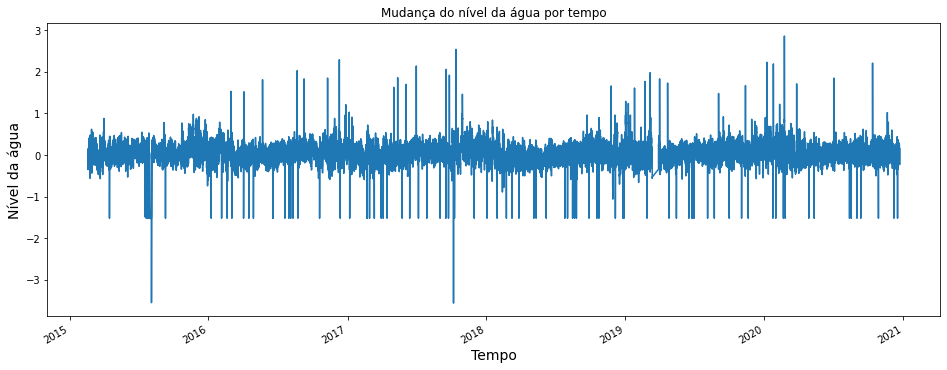

In [4]:
# Plotando a variação do nível da água com o tempo
data = df.water_level

data.plot(figsize=(16,6));
plt.title('Mudança do nível da água por tempo')
plt.xlabel('Tempo', size= 14 )
plt.ylabel('Nível da água', size = 14);

### Detectando anomalias fixando o range manualamente

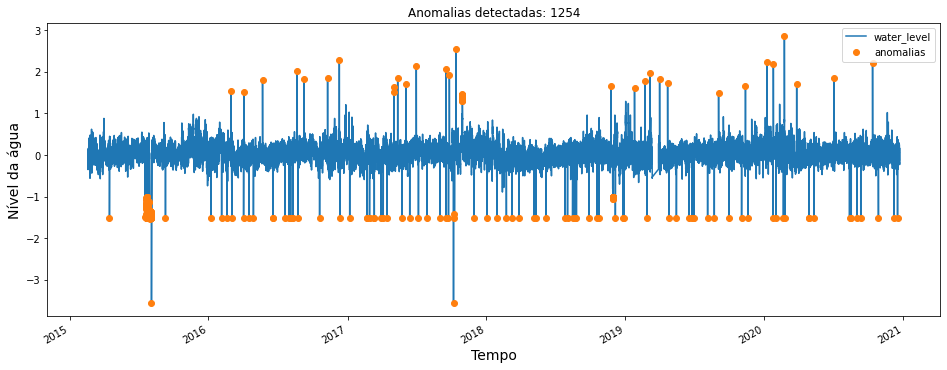

In [5]:
# Criando um range manual
range_anomalies = RangeDetector(-1, 1.3).detect(data)

# Criando um dataframe paraos valores detectados
detected = data.to_frame()
detected["anomalias"] = data[range_anomalies.values]

# Plotando os gráficos com as anomalias
detected.plot(style=['-', 'o'], figsize=(16,6), title=f"Anomalias detectadas: {range_anomalies.sum()}")
plt.xlabel('Tempo', size= 14 )
plt.ylabel('Nível da água', size = 14);

### Detectando anomalias fixando o range automaticamente

In [6]:
data_clean = data.copy()
data_clean[range_anomalies.values] = np.nan

N = 1000
normal_data, test_data = data[:N], data[N:]

anomaly_detector = CombinedDetector([RangeDetector(), DiffDetector()])
anomaly_detector.fit(normal_data)
detected_anomalies = anomaly_detector.detect(test_data)

In [7]:
detected_anomalies.head()

2015-02-25 12:30:00    False
2015-02-25 12:40:00    False
2015-02-25 12:50:00    False
2015-02-25 13:00:00    False
2015-02-25 13:20:00    False
dtype: bool

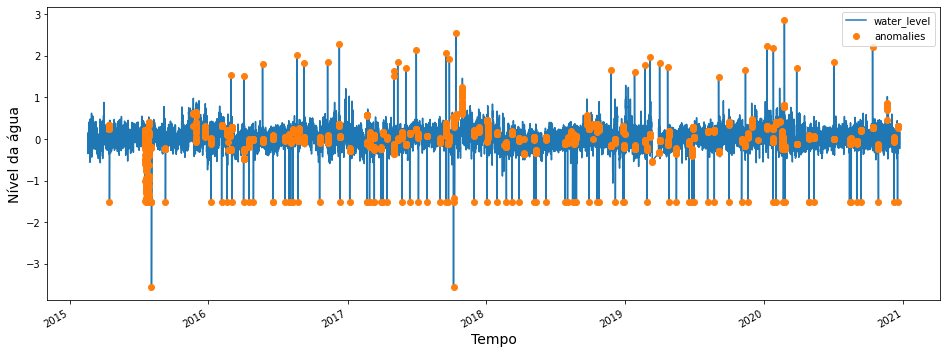

In [8]:

detector = RollingStandardDeviationDetector(10, 0.1)
std_anomalies = detector.detect(data)

detected = data.to_frame()
detected["anomalies"] = data[std_anomalies.values]
detected.plot(style=['-', 'o'], figsize=(16,6))
plt.xlabel('Tempo', size= 14 )
plt.ylabel('Nível da água', size = 14);

## Usando a biblioteca anom_detect

Vamos comparar o desempenho das funções da bibioteca `tsod` com uma outra biblioteca chamada `anom_detect` para determinar os pontos anomalos do conjunto de dados. Vamos usar apenas uma amostra do dataframe original para verificarmos o desempenho da classificação dos pontos anomalos.

In [9]:
# Tomando uma amostra do dataframe df.

dff = df.sample(frac = 0.02)

Para que possamos usar a funação anom_detect precissamos antes resetar os índices da amostra dff. Já que essa função não usa formato de data, apenas os índices de cada registro.

In [10]:
# Resetando os índices do dataframe dff
dff = dff.reset_index(drop = True)
dff

,water_level
0,0.00
1,-0.06
2,0.19
3,0.20
4,0.38
...,...
5995,0.06
5996,0.11
5997,-0.22
5998,-0.04


Além do gráfico exibir a posição dos pontos anômalos o método anom_detect adiciona os gráficos dos valores do desvio padrão estático para as médias móveis, simga1 e sigma2.

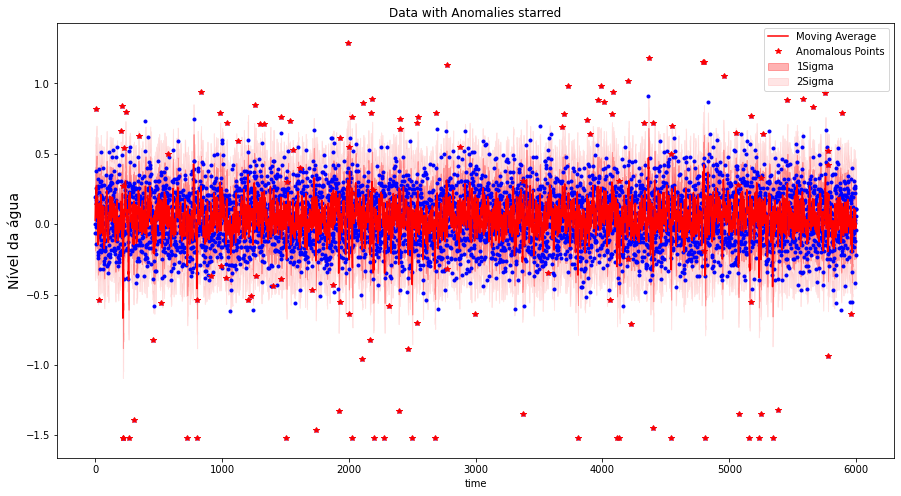

In [11]:
# Importando a biblioteca anom_detect.
from anom_detect import anom_detect

an = anom_detect()

anomalus = dff

an.evaluate(anomalus)

an.plot()
plt.ylabel('Nível da água', size = 14);

Claramente o método anom_detecd consome muito mias tempo que quando usamos a biblioteca `tsod`. Mas temos que levar em conta que construção do gráfico acima é mais complexo devido a adição da contrubuição do desvio padrão estático. Notamos ainda que a visualição dos pontos anômalos é mais clara do que para o método `tsod`. Dependendo do problema, pode ser mais conveniente usar `anom_detected`.

## Usando o PyCaret

O módulo de detecção de anomalias `pycaret.anomaly` é um módulo de machine learning responsável por identificar itens raros, eventos e observasões que diferem significativamente da maioria dos dados.

In [12]:
import matplotlib.pyplot as plt
df = df.reset_index()
df

,index,water_level
0,2015-02-18 12:30:00,-0.23
1,2015-02-18 12:40:00,-0.25
2,2015-02-18 12:50:00,-0.26
3,2015-02-18 13:00:00,-0.27
4,2015-02-18 13:10:00,-0.28
...,...,...
299995,2020-12-22 11:40:00,-0.21
299996,2020-12-22 11:50:00,-0.21
299997,2020-12-22 12:00:00,-0.20
299998,2020-12-22 12:10:00,-0.19


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 2 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   index        300000 non-null  datetime64[ns]
 1   water_level  300000 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.6 MB


In [14]:
dfs = df.rename(columns = {'index': 'time'})
dfs

,time,water_level
0,2015-02-18 12:30:00,-0.23
1,2015-02-18 12:40:00,-0.25
2,2015-02-18 12:50:00,-0.26
3,2015-02-18 13:00:00,-0.27
4,2015-02-18 13:10:00,-0.28
...,...,...
299995,2020-12-22 11:40:00,-0.21
299996,2020-12-22 11:50:00,-0.21
299997,2020-12-22 12:00:00,-0.20
299998,2020-12-22 12:10:00,-0.19


In [15]:
dfs = dfs.sample(frac = 0.02)

In [16]:
dfs = dfs.reset_index(drop= True)

dfs = dfs.sort_values(by=['time'])
dfs

,time,water_level
5578,2015-02-18 15:10:00,-0.33
57,2015-02-18 15:50:00,-0.32
2714,2015-02-18 23:10:00,-0.07
4238,2015-02-19 01:30:00,-0.25
5707,2015-02-19 10:10:00,0.10
...,...,...
4016,2020-12-21 10:50:00,-0.06
1847,2020-12-21 13:40:00,0.14
3813,2020-12-22 00:40:00,-0.06
2158,2020-12-22 07:30:00,-0.05


In [17]:
import time
import datetime

In [19]:
dfs['day'] = pd.to_datetime(dfs["time"]).dt.day

dfs['day_name'] = pd.to_datetime(dfs["time"]).dt.day_name()

dfs['day_of_year'] = pd.to_datetime(dfs["time"]).dt.dayofyear

dfs['week_of_year'] = pd.to_datetime(dfs["time"]).dt.weekofyear

dfs['hour'] = pd.to_datetime(dfs["time"]).dt.hour

dfs['is_weekday'] = pd.to_datetime(dfs["time"]).dt.weekday

O `setup` consegue inferir os tipos de dados de entrada na função além de definir os pepilines que irá executar o pre-processamento dos dados.

In [ ]:
from pycaret.anomaly import *
s = setup(dfs, session_id = 123)

,Description,Value
0,session_id,123
1,Original Data,"(6000, 8)"
2,Missing Values,False
3,Numeric Features,5
4,Categorical Features,2
5,Ordinal Features,False
6,High Cardinality Features,False
7,High Cardinality Method,None
8,Transformed Data,"(6000, 66)"
9,CPU Jobs,-1


Uma vez processado o `setup` com os dados o pycaret irá gera 12 modelos de avaliação de detecção de anomalias. 

In [ ]:
# Criando os modelos de avaliação
models()

,Name,Reference
ID,,
abod,Angle-base Outlier Detection,pyod.models.abod.ABOD
cluster,Clustering-Based Local Outlier,pyod.models.cblof.CBLOF
cof,Connectivity-Based Local Outlier,pyod.models.cof.COF
iforest,Isolation Forest,pyod.models.iforest.IForest
histogram,Histogram-based Outlier Detection,pyod.models.hbos.HBOS
knn,K-Nearest Neighbors Detector,pyod.models.knn.KNN
lof,Local Outlier Factor,pyod.models.lof.LOF
svm,One-class SVM detector,pyod.models.ocsvm.OCSVM
pca,Principal Component Analysis,pyod.models.pca.PCA


In [ ]:
# Treinando o modelo 'iforest' para determinar os valores anômalos
iforest = create_model('iforest', fraction = 0.1)
iforest_results = assign_model(iforest)
iforest_results.head()

,time,water_level,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
1854,2015-02-18 21:00:00,0.02,18,Wednesday,49,8,21,2,0,-0.000913
2427,2015-02-18 21:20:00,0.03,18,Wednesday,49,8,21,2,0,-0.000913
2573,2015-02-19 01:40:00,-0.25,19,Thursday,50,8,1,3,0,-0.013414
192,2015-02-19 13:20:00,-0.08,19,Thursday,50,8,13,3,0,-0.017597
2092,2015-02-20 21:40:00,0.31,20,Friday,51,8,21,4,1,0.001063


In [ ]:
# Check de anomalias
iforest_results[iforest_results['Anomaly'] == 1].head()

,time,water_level,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
2092,2015-02-20 21:40:00,0.31,20,Friday,51,8,21,4,1,0.001063
1905,2015-02-25 22:20:00,-0.15,25,Wednesday,56,9,22,2,1,0.001140
3355,2015-02-27 05:50:00,-0.28,27,Friday,58,9,5,4,1,0.017620
4074,2015-02-28 01:40:00,0.04,28,Saturday,59,9,1,5,1,0.003225
4607,2015-02-28 02:00:00,0.06,28,Saturday,59,9,2,5,1,0.012337


In [ ]:
# Fixando os índices como 'time' para criar o plot com valores anômalos

iforest_results.set_index('time', drop=True, inplace=True)

iforest_results

,water_level,day,day_name,day_of_year,week_of_year,hour,is_weekday,Anomaly,Anomaly_Score
time,,,,,,,,,
2015-02-18 21:00:00,0.02,18,Wednesday,49,8,21,2,0,-0.000913
2015-02-18 21:20:00,0.03,18,Wednesday,49,8,21,2,0,-0.000913
2015-02-19 01:40:00,-0.25,19,Thursday,50,8,1,3,0,-0.013414
2015-02-19 13:20:00,-0.08,19,Thursday,50,8,13,3,0,-0.017597
2015-02-20 21:40:00,0.31,20,Friday,51,8,21,4,1,0.001063
...,...,...,...,...,...,...,...,...,...
2020-12-21 00:20:00,0.13,21,Monday,356,52,0,0,0,-0.035380
2020-12-21 14:30:00,0.20,21,Monday,356,52,14,0,0,-0.028843
2020-12-21 21:30:00,-0.13,21,Monday,356,52,21,0,0,-0.019757


In [ ]:
# Plotando o gráfico com os valores anômalos
import plotly.graph_objects as go
import plotly.express as px
# plot value on y-axis and date on x-axis
fig = px.line(iforest_results, x=iforest_results.index, y="water_level", title='Nível da Água -  Detecção de valores anômalos', template = 'plotly_dark')
# create list of outlier_dates
outlier_dates = iforest_results[iforest_results['Anomaly'] == 1].index
# obtain y value of anomalies to plot
y_values = [iforest_results.loc[i]['water_level'] for i in outlier_dates]
fig.add_trace(go.Scatter(x=outlier_dates, y=y_values, mode = 'markers', 
                name = 'Anomaly', 
                marker=dict(color='red',size=10)))
        
fig.show()

O plot usando o pycaret para detectar os valores anômalos é bem semelhante ao plot que obtivemos usando a biblioteca tsod. Usamos uma amostra de apenas 2% do dataset original para treinar com pycaret de modo que o médoto usando as ferramentas da biblioteca tsod tivemos um desempenho computacional superior. Contudo, usando o método de detecção de anomalia do pycaret podemos facilmente identificar os valores que são anômalos dentro do dataframe.

In [ ]:
# Determinando a quantidade de anomalias contidas na base de dados.
import seaborn as sns

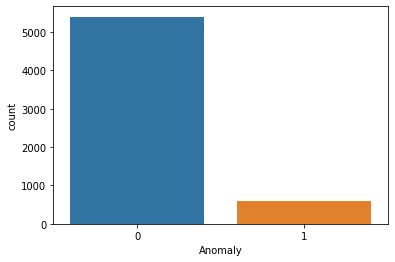

In [ ]:

sns.countplot(x = iforest_results['Anomaly'], data = iforest_results);